# MILB - Check Retention Distribution
* StellarAlgo
* Ryan Kazmerik
* August 2, 2022

In [ ]:
import boto3 
import json
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

from pycaret.classification import *
from shared_utilities import helpers

In [ ]:
from importlib import reload
reload(helpers)

### Let's grab the training and eval datasets currently in prod:

In [ ]:
df_train = pd.read_csv("./data/train.csv")
df_eval = pd.read_csv("./data/eval.csv")

### Let's setup our new model:

In [57]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentDate"
    ],
    ignore_features=[
        "dimCustomerMasterId",
        "productGrouping",
        "year"
    ],
    numeric_features=[
        "attendancePercent", 
        "distToVenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "renewedBeforeDays",
        "source_tenure",
        "totalSpent"
    ],
    silent=True,
    verbose=False
);

best_model = compare_models(
    fold=2,
    include=["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6633,0.7235,0.5851,0.6270,0.6053,0.3123,0.3129,2.5350


### Let's finalize our new model so it can be used to make predictions:

In [ ]:
final_model = create_model(best_model)
new_model = finalize_model(final_model)

### Let's also load in the model currently being used in production:

In [59]:
prod_model = load_model('./models/model(2022-05-12)')

Transformation Pipeline and Model Successfully Loaded


### Let's use the new and existing model to make predictions on the 2022 season:

In [64]:
df_inference = pd.read_csv("./data/inference.csv")
df_inference.columns=['attendancePercent','clientcode','dimcustomermasterid','distToVenue','isNextYear_Buyer','lkupclientid','missed_games_1','missed_games_2','missed_games_over_2','productGrouping','recency','recentDate','renewedBeforeDays','source_tenure','totalSpent','year']

df_inference = df_inference.loc[df_inference['lkupclientid']==20]

In [65]:
df_new_predictions = predict_model(new_model, data=df_inference, raw_score=True)
df_prod_predictions = predict_model(prod_model, data=df_inference, raw_score=True)

### Let's have a look at the distribution of scores for both models:

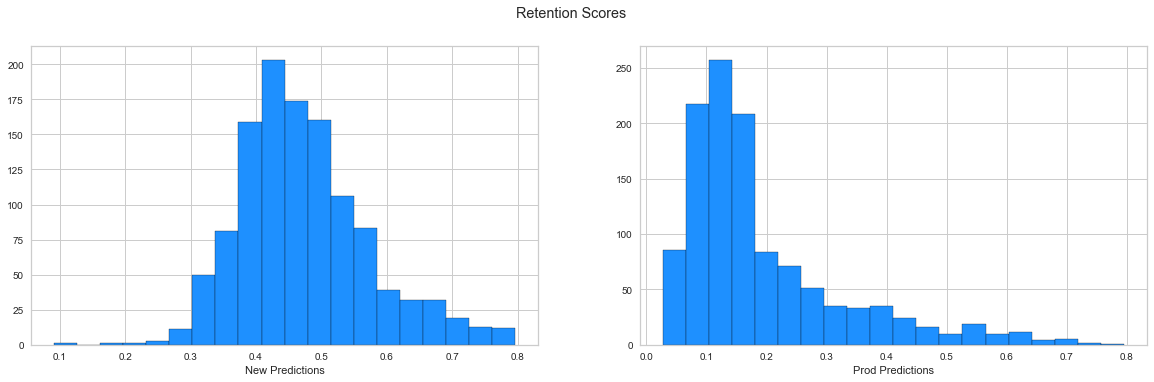

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Retention Scores')
ax1.hist(df_new_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax2.hist(df_prod_predictions['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('New Predictions')
ax2.set_xlabel('Prod Predictions')

fig.figure.set_figwidth(20)

### Done